# Randomisation

This tab allows to control the balance between groups and to perform subgroup analyses. First, you can select the metadata that will be monitored in this tab (list of selected metadata is saved in the config file). Second, the selected metadata are listed in a table and size of corresponding subgroups are given. An indicator of balance is also provided for each metadata, see below for details.

In [1]:
import os
import sys
sys.path.append("C:\\Users\\Fabien Boux\\Code\\ClinLib")

from functions.config import Config
config = Config()
config.read()

from clinlib.database import Database
database = Database(config.get_value('database', section='PATH'), idlength=3)
database.add_resource({'metadata': os.path.join(config.get_value('database', section='PATH'), config.get_value('metadata', section='PATH'))})

In [2]:
import ipywidgets as widgets

if config.is_key('list_metadata'):
    list_metadata = config.get_value('list_metadata')
else:
    list_metadata = config.extract_config_values('list_metadata')
    config.write()
    
if config.is_key('monitored_metadata'):
    list_selected = config.get_value('monitored_metadata')
else:
    list_selected = list_metadata[:1]

all_metadata = widgets.Select(
    options=list_metadata,
    value=list_metadata[0],
    description='Metadata:',
    disabled=False
)

selected_metadata = widgets.Select(
    options=list_selected,
    value=list_selected[0],
    description='Monitored:',
    disabled=False
)

def on_button_add_clicked(var):
    if all_metadata.value not in list_selected:
        list_selected.append(all_metadata.value)
        list_selected.sort()
        selected_metadata.options = list_selected

def on_button_remove_clicked(var):
    list_selected.remove(selected_metadata.value)
    selected_metadata.options = list_selected

def on_button_save_clicked(var):
    config.set_value(list_selected, 'monitored_metadata', section='METADATA')
    config.write()
    
button_add = widgets.Button(description='Add', command=on_button_add_clicked)
button_remove = widgets.Button(description='Remove', command=on_button_remove_clicked)
button_save = widgets.Button(description='Save', command=on_button_save_clicked)

button_add.on_click(on_button_add_clicked)
button_remove.on_click(on_button_remove_clicked)
button_save.on_click(on_button_save_clicked)

widgets.HBox([all_metadata, widgets.VBox([button_add, button_remove, button_save]), selected_metadata])

## Balance

The next table reports the selected metadata. The indicator of balance is the coefficient of variation (ratio between standard deviation and mean):
- in range 0-10% (*green*): subgroups are considered balanced,
- around 20% (*orange*): risk of unbalancy (< 20% low risk and > 20% high risk),
- and from 30% and above (*red*): subgroups are considered unbalanced.

In [3]:
import pandas as pd
import numpy as np

metadata = database.get_metadata(which='all')

group = metadata['Group']
group_labels = group.unique()

metadata = metadata[list_selected]

df = pd.DataFrame([], columns=group_labels, index=[])
for m in list_selected:
    if len(metadata[m].unique()) > 10:
        labels = [np.quantile(metadata[m], q) for q in [0, 0.25, 0.50, 0.75]]
        for i in range(1, len(labels)):
            df.loc['{}: {:.2f}-{:.2f}'.format(m, labels[i-1], labels[i])] = [((labels[i-1] <= metadata[m][group == g]) & (metadata[m][group == g] < labels[i])).sum() for g in group_labels]
    else:
        labels = metadata[m].unique()
        for i in labels:
            df.loc['{}: {}'.format(m, str(i))] = [(metadata[m][group == g]==i).sum() for g in group_labels]

balance = pd.Series([np.nan]*len(df.index), index=df.index)
for i in df.index:
    if (df.loc[i] > 4).all():
        balance[i] = round(100 * df.loc[i].values.std() / df.loc[i].values.mean(), 1)
        
df.insert(loc=len(df.columns), column='Balance', value=balance)

import matplotlib
N = 200
vals = np.ones((N, 4))
vals[:, 0] = np.concatenate((np.linspace(0,1, N//2), np.linspace(1, 1, N//2)), axis=None)
vals[:, 1] = np.concatenate((np.linspace(.9, .5, N//2), np.linspace(.5, 0, N//2)), axis=None)
vals[:, 2] = np.concatenate((np.linspace(0, 0, N//2), np.linspace(0, 0, N//2)), axis=None)
my_cmap = matplotlib.colors.ListedColormap(vals)

def make_pretty(styler):
    styler.background_gradient(axis=None, vmin=10, vmax=30, cmap=my_cmap)
    styler.format(precision=1)
    return styler

df.style.pipe(make_pretty)


,0,1,Balance
Metadata 0: 3,25,31,10.7
Metadata 0: 0,18,33,29.4
Metadata 0: 2,21,29,16.0
Metadata 0: 1,21,22,2.3
Metadata 1: 1,44,62,17.0
Metadata 1: 0,41,53,12.8
Metadata 4: 0.10-2.20,18,32,28.0
Metadata 4: 2.20-4.21,19,31,24.0
Metadata 4: 4.21-6.22,22,28,12.0
Metadata 8: 2,19,29,20.8


## Subgroup analysis

The next graph is a *forest plot*. This figure is used to easily account for benefit in specific subgroups. The benefit can be investigated using different metrics: risk ratio, hazard ratio, or median event time. For each line (each subgroup), the metric chosen is providen (*mark*) with a confidence index (*line*) and the benefit is in favor of the first group (respectivelly, the second group) if the mark is positionned to the right (respectivelly, to the left) of the vertical line "no effect". This interpretation is valid for an event related to treatment benefit (e.g., cured patient), for survival analysis invert right and left.

C:\ProgramData\Anaconda3\envs\NanoRad\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


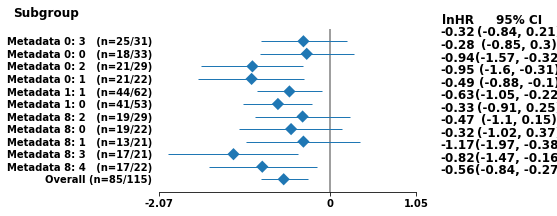

In [4]:
from ipywidgets import interactive
from functions.graph import forest_plot

# w = widgets.RadioButtons(
#     options=['pepperoni', 'pineapple', 'anchovies'],
# #    value='pineapple', # Defaults to 'pineapple'
# #    layout={'width': 'max-content'}, # If the items' names are long
#     description='Pizza topping:',
#     disabled=False
# )

def plot_forest(Criteria='Hazard ratio'):
    forest_plot(database, list_selected)
    
import ipywidgets as widgets
from ipywidgets import interactive

interactive(plot_forest, Criteria=['Hazard ratio', 'Risk ratio', 'Median event time'])